# Fabric importance
In this notebook a train test based on weeks 101, 102, 103 is created, and tested on week 104.

### Import of libraries and datasets

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
articles = pd.read_parquet("../generated_data/articles_with_fabric_namenum.parquet")
articles

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,fabric_num,fabric_name
0,108775015,108775,12855,253,9,0,1010016,0,9,0,...,0,1,0,16,30,1002,2,8834,[0],[jersey]
1,108775044,108775,12855,253,9,0,1010016,0,10,2,...,0,1,0,16,30,1002,2,8834,[0],[jersey]
2,108775051,108775,44846,253,9,0,1010017,3,11,11,...,0,1,0,16,30,1002,2,8834,[0],[jersey]
3,110065001,110065,8159,306,13,4,1010016,0,9,0,...,7,1,0,61,5,1017,4,8243,[1],[microfibre]
4,110065002,110065,8159,306,13,4,1010016,0,10,2,...,7,1,0,61,5,1017,4,8243,[1],[microfibre]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,953450001,953450,24043,302,14,7,1010014,6,9,0,...,2,3,3,26,16,1021,13,28026,"[4, 13, 3]","[cotton, knit, elastic]"
105538,953763001,953763,24027,253,9,0,1010016,0,9,0,...,0,1,0,2,15,1005,0,28025,[8],[polyester]
105539,956217002,956217,24040,265,1,2,1010016,0,9,0,...,0,1,0,18,12,1005,0,28024,[0],[jersey]
105540,957375001,957375,24041,72,48,3,1010016,0,9,0,...,1,2,2,52,25,1019,1,28023,"[5, 6]","[plastic, hair]"


In [3]:
a2 = pd.read_csv("../data/articles.csv")

In [4]:
style_cols = ["graphical_appearance_name", "perceived_colour_master_name", "section_name", "index_group_name"]
for col in style_cols:
    print(col)
    print(a2[col].unique())
    print()

graphical_appearance_name
['Solid' 'Stripe' 'All over pattern' 'Melange' 'Transparent' 'Metallic'
 'Application/3D' 'Denim' 'Colour blocking' 'Dot' 'Other structure'
 'Contrast' 'Treatment' 'Check' 'Chambray' 'Front print'
 'Glittering/Metallic' 'Mixed solid/pattern' 'Placement print'
 'Other pattern' 'Neps' 'Embroidery' 'Lace' 'Jacquard' 'Unknown' 'Argyle'
 'Slub' 'Mesh' 'Sequin' 'Hologram']

perceived_colour_master_name
['Black' 'White' 'Beige' 'Grey' 'Blue' 'Pink' 'Lilac Purple' 'Red' 'Mole'
 'Orange' 'Metal' 'Brown' 'Turquoise' 'Yellow' 'Khaki green' 'Green'
 'undefined' 'Unknown' 'Yellowish Green' 'Bluish Green']

section_name
['Womens Everyday Basics' 'Womens Lingerie'
 'Womens Nightwear, Socks & Tigh' 'Baby Essentials & Complements'
 'Men Underwear' 'Mama' 'Womens Small accessories' 'Men H&M Sport'
 'Kids Boy' 'Divided Basics' 'Girls Underwear & Basics' 'Mens Outerwear'
 'Womens Big accessories' 'Divided Accessories'
 'Womens Swimwear, beachwear' 'Divided Selected' 'Boys Underwe

In [5]:
customers = pd.read_parquet("../data/customers.parquet")
customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,6883939031699146327,-1,-1,0,0,49,6305
1,11246327431398957306,-1,-1,0,0,25,33726
2,18439897732908966680,-1,-1,0,0,24,3247
3,18352672461570950206,-1,-1,0,0,54,168643
4,18162778555210377306,1,1,0,1,52,168645
...,...,...,...,...,...,...,...
1371975,7551062398649767985,-1,-1,0,0,24,50351
1371976,9305341941720086711,-1,-1,0,0,21,80169
1371977,10160427316885688932,1,1,0,1,21,106737
1371978,2551401172826382186,1,1,0,1,18,111894


In [6]:
#Limit transactions to THIS FALL:
#TRAIN = WEEK 101-103 
#TEST = WEEK 104
tr = pd.read_parquet("../data/transactions_train.parquet")
tr.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week
25784,2018-09-20,1728846800780188,519773001,0.028458,2,0
25785,2018-09-20,1728846800780188,578472001,0.032525,2,0
5389,2018-09-20,2076973761519164,661795002,0.167797,2,0
5390,2018-09-20,2076973761519164,684080003,0.101678,2,0
47429,2018-09-20,2918879973994241,662980001,0.033881,1,0


In [7]:
tr_this_fall = tr[(tr.week > 100) & (tr.week < 104)]
print(tr_this_fall.shape)

tr_this_fall_test = tr[(tr.week == 104)]
print(tr_this_fall_test.shape)

(803079, 6)
(240311, 6)


In [8]:
tr_this_fall = tr_this_fall.merge(articles, on="article_id")
tr_this_fall_test = tr_this_fall_test.merge(articles, on="article_id")

In [9]:
tr_this_fall

,t_dat,customer_id,article_id,price,sales_channel_id,week,product_code,prod_name,product_type_no,product_type_name,...,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,fabric_num,fabric_name
0,2020-08-26,116809474287335,915529003,0.033881,1,101,915529,7046,252,2,...,0,1,0,15,0,1003,3,10909,"[13, 8, 24]","[knit, polyester, wool]"
1,2020-08-26,73668978180784161,915529003,0.032864,2,101,915529,7046,252,2,...,0,1,0,15,0,1003,3,10909,"[13, 8, 24]","[knit, polyester, wool]"
2,2020-08-26,73668978180784161,915529003,0.032864,2,101,915529,7046,252,2,...,0,1,0,15,0,1003,3,10909,"[13, 8, 24]","[knit, polyester, wool]"
3,2020-08-26,471953522968279895,915529003,0.027102,2,101,915529,7046,252,2,...,0,1,0,15,0,1003,3,10909,"[13, 8, 24]","[knit, polyester, wool]"
4,2020-08-26,638153562390283142,915529003,0.033881,1,101,915529,7046,252,2,...,0,1,0,15,0,1003,3,10909,"[13, 8, 24]","[knit, polyester, wool]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803074,2020-09-15,18112256725999533387,837251001,0.011847,2,103,837251,24970,77,35,...,6,1,0,66,9,1019,1,25053,[5],[plastic]
803075,2020-09-15,18173664097779911215,876148004,0.100390,2,103,876148,4338,262,6,...,1,2,2,53,1,1007,9,5755,"[8, 24]","[polyester, wool]"
803076,2020-09-15,18173664097779911215,876148004,0.100390,2,103,876148,4338,262,6,...,1,2,2,53,1,1007,9,5755,"[8, 24]","[polyester, wool]"
803077,2020-09-15,18182768163446748466,681373017,0.008458,1,103,681373,438,275,11,...,1,2,2,53,1,1012,18,343,"[0, 3]","[jersey, elastic]"


In [10]:
cus_this_fall = tr_this_fall["customer_id"].unique().tolist()
len(cus_this_fall)

190944

In [11]:
cus_this_fall_test = tr_this_fall_test["customer_id"].unique().tolist()
len(cus_this_fall_test)

68984

In [12]:
art_this_fall = tr_this_fall["article_id"].unique().tolist()
len(art_this_fall)

26503

In [13]:
art_this_fall_test = tr_this_fall_test["article_id"].unique().tolist()
len(art_this_fall_test)

17986

### Articles Matrix

In [14]:
#create the correspondence between article id and index
index_to_art_id = pd.DataFrame({'article_id': art_this_fall})
index_to_art_id_test = pd.DataFrame({'article_id': art_this_fall_test})

In [15]:
index_to_art_id.sort_values(by='article_id')
index_to_art_id['original_index'] = index_to_art_id.index
index_to_art_id.head()

,article_id,original_index
0,915529003,0
1,935858001,1
2,806131001,2
3,873217004,3
4,826498001,4


In [16]:
index_to_art_id_test.sort_values(by='article_id')
index_to_art_id_test['original_index'] = index_to_art_id_test.index
index_to_art_id_test.head()

,article_id,original_index
0,869331006,0
1,866731001,1
2,896152002,2
3,915526001,3
4,878085001,4


In [17]:
#considering just the articles in the weeks we're interested in
articles_this_fall = articles[articles['article_id'].isin(art_this_fall)]
articles_this_fall_test = articles[articles['article_id'].isin(art_this_fall_test)]

In [18]:
#creating reduced datasets for the style characteristics
articles_this_fall_fabric = articles_this_fall[['article_id', 'fabric_num']]
articles_this_fall_style = articles_this_fall[["article_id", "graphical_appearance_name", "perceived_colour_master_name", "section_name", "index_group_name"]]
articles_this_fall_fabric_test = articles_this_fall_test[['article_id', 'fabric_num']]
articles_this_fall_style_test = articles_this_fall_test[["article_id", "graphical_appearance_name", "perceived_colour_master_name", "section_name", "index_group_name"]]

print("training")
print(articles_this_fall_fabric.shape)
print(articles_this_fall_style.shape)
print("test")
print(articles_this_fall_fabric_test.shape)
print(articles_this_fall_style_test.shape)

training
(26503, 2)
(26503, 5)
test
(17986, 2)
(17986, 5)


In [19]:
#creating matrix for fabric

from sklearn.preprocessing import MultiLabelBinarizer

#I make sure that every value inside fabric num lists is counted as a possible value
mlb = MultiLabelBinarizer(sparse_output=True)

articles_this_fall_fabric = articles_this_fall_fabric.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(articles_this_fall_fabric.pop('fabric_num')),
                index=articles_this_fall_fabric.index,
                columns=mlb.classes_))

articles_this_fall_fabric.head()

,article_id,-1,0,1,2,3,4,5,6,7,...,91,92,94,95,97,98,99,100,103,104
1,108775044,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,110065011,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,111565001,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,111586001,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,111593001,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
#I make sure that every value inside fabric num lists is counted as a possible value
mlb = MultiLabelBinarizer(sparse_output=True)

articles_this_fall_fabric_test = articles_this_fall_fabric_test.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(articles_this_fall_fabric_test.pop('fabric_num')),
                index=articles_this_fall_fabric_test.index,
                columns=mlb.classes_))

articles_this_fall_fabric_test.head()

,article_id,-1,0,1,2,3,4,5,6,7,...,82,83,84,90,91,92,94,97,101,103
1,108775044,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,111565001,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,111586001,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,111593001,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,111609001,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#remove article id
articles_this_fall_fabric = articles_this_fall_fabric.drop(['article_id'], axis=1)
#remove article id
articles_this_fall_fabric_test = articles_this_fall_fabric_test.drop(['article_id'], axis=1)

In [22]:
#creating matrix for other features
one_hot_encoded = pd.get_dummies(articles_this_fall[['graphical_appearance_name', 'perceived_colour_master_name', 'section_name', 'index_group_name']], columns=['graphical_appearance_name', 'perceived_colour_master_name', 'section_name', 'index_group_name'])
one_hot_encoded = one_hot_encoded.astype(int)
one_hot_encoded

,graphical_appearance_name_0,graphical_appearance_name_1,graphical_appearance_name_2,graphical_appearance_name_3,graphical_appearance_name_4,graphical_appearance_name_5,graphical_appearance_name_6,graphical_appearance_name_7,graphical_appearance_name_8,graphical_appearance_name_9,...,section_name_49,section_name_50,section_name_52,section_name_54,section_name_55,index_group_name_0,index_group_name_1,index_group_name_2,index_group_name_3,index_group_name_4
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
105536,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
105537,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
105538,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [23]:
one_hot_encoded_test = pd.get_dummies(articles_this_fall_test[['graphical_appearance_name', 'perceived_colour_master_name', 'section_name', 'index_group_name']], columns=['graphical_appearance_name', 'perceived_colour_master_name', 'section_name', 'index_group_name'])
one_hot_encoded_test = one_hot_encoded_test.astype(int)
one_hot_encoded_test

,graphical_appearance_name_0,graphical_appearance_name_1,graphical_appearance_name_2,graphical_appearance_name_3,graphical_appearance_name_4,graphical_appearance_name_5,graphical_appearance_name_6,graphical_appearance_name_7,graphical_appearance_name_8,graphical_appearance_name_9,...,section_name_48,section_name_49,section_name_52,section_name_54,section_name_55,index_group_name_0,index_group_name_1,index_group_name_2,index_group_name_3,index_group_name_4
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
105536,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
105537,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
105538,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [24]:
#merge the two matrices
merged_matrix_art = one_hot_encoded.join(articles_this_fall_fabric)
merged_matrix_art_test = one_hot_encoded_test.join(articles_this_fall_fabric_test)

In [25]:
merged_matrix_art = csr_matrix(merged_matrix_art.values)
print(merged_matrix_art)

  (0, 0)	1
  (0, 32)	1
  (0, 80)	1
  (0, 104)	1
  (0, 110)	1
  (1, 0)	1
  (1, 36)	1
  (1, 55)	1
  (1, 104)	1
  (1, 111)	1
  (2, 0)	1
  (2, 30)	1
  (2, 81)	1
  (2, 104)	1
  (2, 112)	1
  (3, 0)	1
  (3, 30)	1
  (3, 81)	1
  (3, 104)	1
  (3, 109)	1
  (4, 0)	1
  (4, 30)	1
  (4, 81)	1
  (4, 104)	1
  (4, 113)	1
  :	:
  (26498, 104)	1
  (26498, 113)	1
  (26498, 123)	1
  (26499, 1)	1
  (26499, 44)	1
  (26499, 62)	1
  (26499, 104)	1
  (26499, 110)	1
  (26500, 6)	1
  (26500, 30)	1
  (26500, 66)	1
  (26500, 107)	1
  (26500, 113)	1
  (26500, 114)	1
  (26500, 123)	1
  (26501, 0)	1
  (26501, 30)	1
  (26501, 65)	1
  (26501, 104)	1
  (26501, 118)	1
  (26502, 0)	1
  (26502, 30)	1
  (26502, 62)	1
  (26502, 104)	1
  (26502, 110)	1


In [26]:
merged_matrix_art_test = csr_matrix(merged_matrix_art_test.values)
print(merged_matrix_art_test)

  (0, 0)	1
  (0, 31)	1
  (0, 78)	1
  (0, 101)	1
  (0, 107)	1
  (1, 0)	1
  (1, 29)	1
  (1, 79)	1
  (1, 101)	1
  (1, 109)	1
  (2, 0)	1
  (2, 29)	1
  (2, 79)	1
  (2, 101)	1
  (2, 106)	1
  (3, 0)	1
  (3, 29)	1
  (3, 79)	1
  (3, 101)	1
  (3, 110)	1
  (4, 0)	1
  (4, 29)	1
  (4, 79)	1
  (4, 101)	1
  (4, 106)	1
  :	:
  (17981, 101)	1
  (17981, 110)	1
  (17981, 120)	1
  (17982, 1)	1
  (17982, 43)	1
  (17982, 60)	1
  (17982, 101)	1
  (17982, 107)	1
  (17983, 6)	1
  (17983, 29)	1
  (17983, 64)	1
  (17983, 104)	1
  (17983, 110)	1
  (17983, 111)	1
  (17983, 120)	1
  (17984, 0)	1
  (17984, 29)	1
  (17984, 63)	1
  (17984, 101)	1
  (17984, 115)	1
  (17985, 0)	1
  (17985, 29)	1
  (17985, 60)	1
  (17985, 101)	1
  (17985, 107)	1


In [27]:
print(merged_matrix_art.shape)
print(merged_matrix_art_test.shape)

(26503, 200)
(17986, 186)


### Customer Style Matrix

In [28]:
#saving the correspondence between customer id and index
index_to_cus_id = pd.DataFrame({'customer_id': cus_this_fall})
index_to_cus_id_test = pd.DataFrame({'customer_id': cus_this_fall_test})

In [29]:
index_to_cus_id.sort_values(by='customer_id')
index_to_cus_id['original_index'] = index_to_cus_id.index
index_to_cus_id.head()

,customer_id,original_index
0,116809474287335,0
1,73668978180784161,1
2,471953522968279895,2
3,638153562390283142,3
4,681106688400816412,4


In [30]:
index_to_cus_id_test.sort_values(by='customer_id')
index_to_cus_id_test['original_index'] = index_to_cus_id_test.index
index_to_cus_id_test.head()

,customer_id,original_index
0,3177658828628418,0
1,1632349621004549139,1
2,2469920280834095392,2
3,2675700164782309956,3
4,3724615329349624368,4


In [31]:
#creating reduced datasets for style characteristics
customers_this_fall_fabric = tr_this_fall[['customer_id', 'fabric_num']]
customers_this_fall_style = tr_this_fall[["customer_id", "graphical_appearance_name", "perceived_colour_master_name", "section_name", "index_group_name"]]
customers_this_fall_fabric_test = tr_this_fall_test[['customer_id', 'fabric_num']]
customers_this_fall_style_test = tr_this_fall_test[["customer_id", "graphical_appearance_name", "perceived_colour_master_name", "section_name", "index_group_name"]]

print("training")
print(customers_this_fall_fabric.shape)
print(customers_this_fall_style.shape)
print("test")
print(customers_this_fall_fabric_test.shape)
print(customers_this_fall_style_test.shape)

training
(803079, 2)
(803079, 5)
test
(240311, 2)
(240311, 5)


In [32]:
print(index_to_cus_id.shape)
print(index_to_cus_id_test.shape)

(190944, 2)
(68984, 2)


In [33]:
customers_this_fall_fabric

,customer_id,fabric_num
0,116809474287335,"[13, 8, 24]"
1,73668978180784161,"[13, 8, 24]"
2,73668978180784161,"[13, 8, 24]"
3,471953522968279895,"[13, 8, 24]"
4,638153562390283142,"[13, 8, 24]"
...,...,...
803074,18112256725999533387,[5]
803075,18173664097779911215,"[8, 24]"
803076,18173664097779911215,"[8, 24]"
803077,18182768163446748466,"[0, 3]"


In [34]:
#creating matrix for fabric

from sklearn.preprocessing import MultiLabelBinarizer

#I make sure that every value inside fabric num lists is counted as a possible value
mlb = MultiLabelBinarizer(sparse_output=True)

customers_this_fall_fabric = customers_this_fall_fabric.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(customers_this_fall_fabric.pop('fabric_num')),
                index=customers_this_fall_fabric.index,
                columns=mlb.classes_))

customers_this_fall_fabric.head()

,customer_id,-1,0,1,2,3,4,5,6,7,...,91,92,94,95,97,98,99,100,103,104
0,116809474287335,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,73668978180784161,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,73668978180784161,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,471953522968279895,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,638153562390283142,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
#I make sure that every value inside fabric num lists is counted as a possible value
mlb = MultiLabelBinarizer(sparse_output=True)

customers_this_fall_fabric_test = customers_this_fall_fabric_test.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(customers_this_fall_fabric_test.pop('fabric_num')),
                index=customers_this_fall_fabric_test.index,
                columns=mlb.classes_))

customers_this_fall_fabric_test.head()

,customer_id,-1,0,1,2,3,4,5,6,7,...,82,83,84,90,91,92,94,97,101,103
0,3177658828628418,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1632349621004549139,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1632349621004549139,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2469920280834095392,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2675700164782309956,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
customers_this_fall_fabric = customers_this_fall_fabric.groupby('customer_id').sum()
#customers_this_fall_fabric_test = customers_this_fall_fabric_test.groupby('customer_id').sum()
#customers_this_fall_fabric_test.head()

In [60]:
customers_this_fall_fabric.sort_values(by='customer_id')
#customers_this_fall_fabric_test.sort_values(by='customer_id')

,-1,0,1,2,3,4,5,6,7,8,...,91,92,94,95,97,98,99,100,103,104
customer_id,,,,,,,,,,,,,,,,,,,,,
28847241659200,0,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
116809474287335,0,0,0,0,0,1,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
200292573348128,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272412481300040,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
519262836338427,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446250046654386343,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18446420423308293068,3,9,1,0,2,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18446590778427270109,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
sparse_cus_fabric = csr_matrix(customers_this_fall_fabric.values)
#sparse_cus_fabric_test = csr_matrix(customers_this_fall_fabric_test.values)
sparse_cus_fabric

<190944x91 sparse matrix of type '<class 'numpy.intc'>'
	with 748128 stored elements in Compressed Sparse Row format>

In [62]:
#creating matrix for other stye characteristics

one_hot_encoded = pd.get_dummies(tr_this_fall[['graphical_appearance_name', 'perceived_colour_master_name', 'section_name', 'index_group_name']], columns=['graphical_appearance_name', 'perceived_colour_master_name', 'section_name', 'index_group_name'])
one_hot_encoded = one_hot_encoded.astype(int)

#one_hot_encoded_test = pd.get_dummies(tr_this_fall_test[['graphical_appearance_name', 'perceived_colour_master_name', 'section_name', 'index_group_name']], columns=['graphical_appearance_name', 'perceived_colour_master_name', 'section_name', 'index_group_name'])
#one_hot_encoded_test = one_hot_encoded_test.astype(int)
#one_hot_encoded_test

In [63]:
one_hot_encoded['customer_id'] = tr_this_fall['customer_id']
#one_hot_encoded_test['customer_id'] = tr_this_fall_test['customer_id']
#one_hot_encoded_test.head()

In [64]:
one_hot_encoded = one_hot_encoded.groupby('customer_id').sum()
#one_hot_encoded_test = one_hot_encoded_test.groupby('customer_id').sum()
#one_hot_encoded_test.head()

In [65]:
one_hot_encoded.shape

(190944, 109)

In [66]:
#merge the two matrices
merged_cus = pd.merge(customers_this_fall_fabric, one_hot_encoded, on="customer_id", how="inner")
merged_cus.sort_values(by='customer_id')

#merged_cus_test = pd.merge(customers_this_fall_fabric_test, one_hot_encoded_test, on="customer_id", how="inner")
#merged_cus_test.sort_values(by='customer_id')

merged_cus


,-1,0,1,2,3,4,5,6,7,8,...,section_name_49,section_name_50,section_name_52,section_name_54,section_name_55,index_group_name_0,index_group_name_1,index_group_name_2,index_group_name_3,index_group_name_4
customer_id,,,,,,,,,,,,,,,,,,,,,
28847241659200,0,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
116809474287335,0,0,0,0,0,1,0,0,0,3,...,0,0,0,0,0,3,0,3,0,0
200292573348128,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
272412481300040,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
519262836338427,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446250046654386343,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
18446420423308293068,3,9,1,0,2,6,0,0,0,0,...,0,0,0,0,0,20,0,0,0,0
18446590778427270109,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0


In [67]:
merged_cus = merged_cus.reset_index()
#merged_cus_test = merged_cus_test.reset_index()
#merged_cus_test

In [68]:
merged_cus = merged_cus.drop("customer_id", axis=1)
#merged_cus_test = merged_cus_test.drop("customer_id", axis=1)

In [ ]:
merged_cus_test.shape

In [ ]:
merged_cus_test.head()

In [69]:
merged_cus.columns = merged_cus.columns.astype(str)
#merged_cus_test.columns = merged_cus_test.columns.astype(str)

In [70]:
#scale the values between 0 and 1

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
merged_cus = scaler.fit_transform(merged_cus)
#merged_cus_test = scaler.fit_transform(merged_cus_test)

C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [71]:
matrice_sparsa_2 = csr_matrix(merged_cus)
#matrice_sparsa_2_test = csr_matrix(merged_cus_test)
print(matrice_sparsa_2)

  (0, 4)	0.023809523809523808
  (0, 5)	0.01639344262295082
  (0, 9)	0.037037037037037035
  (0, 18)	0.05555555555555555
  (0, 23)	0.058823529411764705
  (0, 91)	0.021505376344086023
  (0, 121)	0.038461538461538464
  (0, 142)	0.02564102564102564
  (0, 181)	0.09090909090909091
  (0, 195)	0.01020408163265306
  (0, 197)	0.020833333333333332
  (1, 5)	0.01639344262295082
  (1, 9)	0.1111111111111111
  (1, 12)	0.03125
  (1, 13)	0.03225806451612903
  (1, 14)	0.12121212121212122
  (1, 25)	0.06060606060606061
  (1, 91)	0.043010752688172046
  (1, 93)	0.043478260869565216
  (1, 95)	0.03125
  (1, 121)	0.07692307692307693
  (1, 122)	0.022222222222222223
  (1, 125)	0.038461538461538464
  (1, 141)	0.08108108108108109
  (1, 142)	0.02564102564102564
  :	:
  (190940, 171)	0.2631578947368421
  (190940, 172)	0.07142857142857142
  (190940, 195)	0.2040816326530612
  (190941, 4)	0.047619047619047616
  (190941, 91)	0.021505376344086023
  (190941, 122)	0.022222222222222223
  (190941, 129)	0.047619047619047616
  (

### Compute similarity between articles and customer style

In [72]:
similarity_matrix_sparse = cosine_similarity(matrice_sparsa_2,merged_matrix_art, dense_output=False)
#similarity_matrix_sparse_test = cosine_similarity(matrice_sparsa_2_test, merged_matrix_art_test, dense_output=False)

In [73]:
import util
%run util.py

In [74]:
topk = get_top_K_values(similarity_matrix_sparse, 2)
print(topk)

  (0, 9501)	0.2961564582332768
  (0, 683)	0.2961564582332768
  (1, 17934)	0.2934924118499252
  (1, 17908)	0.2934924118499252
  (2, 20496)	0.46909810216657327
  (2, 13020)	0.46909810216657327
  (3, 3844)	0.49069429005070897
  (3, 3308)	0.49069429005070897
  (4, 3769)	0.35573773368891526
  (4, 2104)	0.4878356035440615
  (5, 12111)	0.3509567096279126
  (5, 11885)	0.2990990863924686
  (6, 20934)	0.4383391973609048
  (6, 1345)	0.4383391973609048
  (7, 16724)	0.4139884868486514
  (7, 2568)	0.430983803677175
  (8, 20368)	0.48687702730718274
  (8, 6324)	0.48687702730718274
  (9, 560)	0.31459572463125324
  (9, 559)	0.31459572463125324
  (10, 21502)	0.25982510650673085
  (10, 21501)	0.25982510650673085
  (11, 15948)	0.36647835580144894
  (11, 6510)	0.36647835580144894
  (12, 20496)	0.23978810651600715
  :	:
  (190931, 7323)	0.5727284212169225
  (190932, 4835)	0.2797525097041795
  (190932, 4142)	0.27830379665085747
  (190933, 25898)	0.2753560642350286
  (190933, 13020)	0.2753560642350286
  (19093

In [ ]:
topk_test = get_top_K_values(similarity_matrix_sparse_test, 2)
print(topk_test)

In [75]:
toprank = get_top_K_ranks(similarity_matrix_sparse, 3)
print(toprank)

  (0, 683)	2
  (0, 9501)	1
  (0, 11283)	3
  (1, 17908)	1
  (1, 17934)	2
  (1, 17935)	3
  (2, 13020)	1
  (2, 20496)	2
  (2, 25898)	3
  (3, 1168)	3
  (3, 3308)	2
  (3, 3844)	1
  (4, 2104)	1
  (4, 3769)	2
  (4, 10864)	3
  (5, 11885)	2
  (5, 12111)	1
  (5, 22746)	3
  (6, 1345)	1
  (6, 4218)	3
  (6, 20934)	2
  (7, 2568)	1
  (7, 16723)	3
  (7, 16724)	2
  (8, 6324)	2
  :	:
  (190935, 18100)	1
  (190936, 4953)	3
  (190936, 10229)	1
  (190936, 18693)	2
  (190937, 3320)	1
  (190937, 20496)	3
  (190937, 25898)	2
  (190938, 468)	2
  (190938, 8867)	3
  (190938, 11885)	1
  (190939, 6510)	3
  (190939, 14859)	1
  (190939, 15948)	2
  (190940, 14373)	3
  (190940, 17739)	2
  (190940, 18100)	1
  (190941, 3374)	2
  (190941, 4585)	3
  (190941, 10230)	1
  (190942, 10257)	3
  (190942, 11995)	1
  (190942, 23681)	2
  (190943, 2162)	3
  (190943, 10270)	1
  (190943, 10271)	2


In [ ]:
toprank_test = get_top_K_ranks(similarity_matrix_sparse_test, 3)
print(toprank_test)

In [76]:
V = toprank.data 
U = toprank.indices  # rows indexes
I = toprank.indptr  # cols indexes

print("Values (V):", V[:3])
print("Rows (U):", U[:3])
print("Columns (I):", I[:3])

Values (V): [2 1 3]
Rows (U): [  683  9501 11283]
Columns (I): [0 3 6]


In [77]:
## TRAIN

num_elements = len(V)

neg_train = pd.DataFrame(columns=['id', 'index_1', 'index_2', 'index_3'])

for i in range(len(I) - 1):
    start_idx = I[i]
    end_idx = I[i + 1]
    
    first_element_indices = U[start_idx:end_idx]
    
    df_to_append = pd.DataFrame({'id': [i], 'index_1': [first_element_indices[0]],
                                 'index_2': [first_element_indices[1]],
                                 'index_3': [first_element_indices[2]]})
    neg_train = pd.concat([neg_train, df_to_append], ignore_index=True)

In [ ]:
Vt = toprank_test.data 
Ut = toprank_test.indices  
It = toprank_test.indptr   

print("Values (V):", Vt[:3])
print("Rows (U):", Ut[:3])
print("Columns (I):", It[:3])

In [148]:
# TEST

num_elements = len(Vt)

neg_train_test = pd.DataFrame(columns=['id', 'index_1', 'index_2', 'index_3'])

for i in range(len(It) - 1):
    start_idx = It[i]
    end_idx = It[i + 1]

    first_element_indices = Ut[start_idx:end_idx]
    
    df_to_append_test = pd.DataFrame({'id': [i], 'index_1': [first_element_indices[0]],
                                 'index_2': [first_element_indices[1]],
                                 'index_3': [first_element_indices[2]]})
    neg_train_test = pd.concat([neg_train_test, df_to_append_test], ignore_index=True)

In [78]:
neg_train.to_parquet("../generated_data/train_test/train_101-103.parquet", index=False) 
#neg_train_test.to_parquet("../generated_data/train_test/cand_104_test.parquet") 

In [36]:
neg_train = pd.read_parquet("../generated_data/train_test/train_101-103.parquet")
neg_train_test = pd.read_parquet("../generated_data/train_test/cand_104_test.parquet")

In [37]:
neg_train["customer_id"] = index_to_cus_id["customer_id"]
neg_train.head()

,id,index_1,index_2,index_3,customer_id
0,0,683,9501,11283,116809474287335
1,1,17908,17934,17935,73668978180784161
2,2,13020,20496,25898,471953522968279895
3,3,1168,3308,3844,638153562390283142
4,4,2104,3769,10864,681106688400816412


In [38]:
neg_train_test["customer_id"] = index_to_cus_id_test["customer_id"]
neg_train_test.head()

,id,index_1,index_2,index_3,customer_id
0,0,5450,6756,6757,3177658828628418
1,1,3235,10885,14250,1632349621004549139
2,2,2294,10895,15274,2469920280834095392
3,3,1641,2855,3034,2675700164782309956
4,4,4700,5511,7432,3724615329349624368


In [39]:
index_to_art_id

,article_id,original_index
0,915529003,0
1,935858001,1
2,806131001,2
3,873217004,3
4,826498001,4
...,...,...
26498,813384002,26498
26499,837251001,26499
26500,876148004,26500
26501,681373017,26501


In [40]:
index_to_art_id_test

,article_id,original_index
0,869331006,0
1,866731001,1
2,896152002,2
3,915526001,3
4,878085001,4
...,...,...
17981,897258002,17981
17982,826154004,17982
17983,889747001,17983
17984,778517001,17984


In [41]:
# find the correspondent article for indexes

neg_train['index_1_id'] = neg_train['index_1'].apply(lambda x: index_to_art_id.loc[x, 'article_id'] if x in index_to_art_id.index else None)
neg_train_test['index_1_id'] = neg_train_test['index_1'].apply(lambda x: index_to_art_id_test.loc[x, 'article_id'] if x in index_to_art_id_test.index else None)

neg_train['index_2_id'] = neg_train['index_2'].apply(lambda x: index_to_art_id.loc[x, 'article_id'] if x in index_to_art_id.index else None)
neg_train['index_3_id'] = neg_train['index_3'].apply(lambda x: index_to_art_id.loc[x, 'article_id'] if x in index_to_art_id.index else None)

neg_train_test['index_2_id'] = neg_train_test['index_2'].apply(lambda x: index_to_art_id_test.loc[x, 'article_id'] if x in index_to_art_id_test.index else None)
neg_train_test['index_3_id'] = neg_train_test['index_3'].apply(lambda x: index_to_art_id_test.loc[x, 'article_id'] if x in index_to_art_id_test.index else None)


In [42]:
neg_train.head()

,id,index_1,index_2,index_3,customer_id,index_1_id,index_2_id,index_3_id
0,0,683,9501,11283,116809474287335,947509001,598515024,859932001
1,1,17908,17934,17935,73668978180784161,807701001,618287010,877461001
2,2,13020,20496,25898,471953522968279895,840475001,821417002,884950002
3,3,1168,3308,3844,638153562390283142,611635003,791587018,610776082
4,4,2104,3769,10864,681106688400816412,917241001,863753003,699923092


In [43]:
neg_train_test.head()

,id,index_1,index_2,index_3,customer_id,index_1_id,index_2_id,index_3_id
0,0,5450,6756,6757,3177658828628418,859139003,849214010,849214001
1,1,3235,10885,14250,1632349621004549139,814641008,884252001,892463001
2,2,2294,10895,15274,2469920280834095392,821398009,910569001,824983013
3,3,1641,2855,3034,2675700164782309956,253448003,743904015,499334003
4,4,4700,5511,7432,3724615329349624368,708485003,874837011,853911001


In [44]:
neg_train_102103 = neg_train[["customer_id", 'index_1_id', 'index_2_id', 'index_3_id']]
neg_test_104 = neg_train_test[["customer_id", 'index_1_id', 'index_2_id', 'index_3_id']]
neg_test_104.head()

,customer_id,index_1_id,index_2_id,index_3_id
0,3177658828628418,859139003,849214010,849214001
1,1632349621004549139,814641008,884252001,892463001
2,2469920280834095392,821398009,910569001,824983013
3,2675700164782309956,253448003,743904015,499334003
4,3724615329349624368,708485003,874837011,853911001


In [45]:
melted_df = pd.melt(neg_train_102103, id_vars=['customer_id'], var_name='index_type', value_name='article_id')
melted_df.sort_values(by=['customer_id', 'article_id'], inplace=True)

melted_df_test = pd.melt(neg_test_104, id_vars=['customer_id'], var_name='index_type', value_name='article_id')
melted_df_test.sort_values(by=['customer_id', 'article_id'], inplace=True)

melted_df_test.head()

,customer_id,index_type,article_id
148517,1402273113592184,index_3_id,843458004
10549,1402273113592184,index_1_id,868053001
79533,1402273113592184,index_2_id,904412002
193821,1827730561464445,index_3_id,810508004
124837,1827730561464445,index_2_id,859619002


In [46]:
melted_df = melted_df.drop("index_type", axis=1)
melted_df_test = melted_df_test.drop("index_type", axis=1)
melted_df.head()

,customer_id,article_id
459028,28847241659200,266873006
77140,28847241659200,594978005
268084,28847241659200,861582001
190944,116809474287335,598515024
381888,116809474287335,859932001


In [47]:
#datarfame with negative samples
melted_df["purchased"] = 0
melted_df_test["purchased"] = 0

In [48]:
#dataframe with positive samples
tr_this_fall["purchased"] = 1
tr_this_fall_test["purchased"] = 1

In [49]:
tr_this_fall

,t_dat,customer_id,article_id,price,sales_channel_id,week,product_code,prod_name,product_type_no,product_type_name,...,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,fabric_num,fabric_name,purchased
0,2020-08-26,116809474287335,915529003,0.033881,1,101,915529,7046,252,2,...,1,0,15,0,1003,3,10909,"[13, 8, 24]","[knit, polyester, wool]",1
1,2020-08-26,73668978180784161,915529003,0.032864,2,101,915529,7046,252,2,...,1,0,15,0,1003,3,10909,"[13, 8, 24]","[knit, polyester, wool]",1
2,2020-08-26,73668978180784161,915529003,0.032864,2,101,915529,7046,252,2,...,1,0,15,0,1003,3,10909,"[13, 8, 24]","[knit, polyester, wool]",1
3,2020-08-26,471953522968279895,915529003,0.027102,2,101,915529,7046,252,2,...,1,0,15,0,1003,3,10909,"[13, 8, 24]","[knit, polyester, wool]",1
4,2020-08-26,638153562390283142,915529003,0.033881,1,101,915529,7046,252,2,...,1,0,15,0,1003,3,10909,"[13, 8, 24]","[knit, polyester, wool]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803074,2020-09-15,18112256725999533387,837251001,0.011847,2,103,837251,24970,77,35,...,1,0,66,9,1019,1,25053,[5],[plastic],1
803075,2020-09-15,18173664097779911215,876148004,0.100390,2,103,876148,4338,262,6,...,2,2,53,1,1007,9,5755,"[8, 24]","[polyester, wool]",1
803076,2020-09-15,18173664097779911215,876148004,0.100390,2,103,876148,4338,262,6,...,2,2,53,1,1007,9,5755,"[8, 24]","[polyester, wool]",1
803077,2020-09-15,18182768163446748466,681373017,0.008458,1,103,681373,438,275,11,...,2,2,53,1,1012,18,343,"[0, 3]","[jersey, elastic]",1


In [50]:
tr_this_fall_test

,t_dat,customer_id,article_id,price,sales_channel_id,week,product_code,prod_name,product_type_no,product_type_name,...,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,fabric_num,fabric_name,purchased
0,2020-09-16,3177658828628418,869331006,0.030492,1,104,869331,18158,306,13,...,26,4,5,21,1005,0,3862,[-1],None,1
1,2020-09-16,1632349621004549139,869331006,0.030492,2,104,869331,18158,306,13,...,26,4,5,21,1005,0,3862,[-1],None,1
2,2020-09-16,1632349621004549139,869331006,0.030492,2,104,869331,18158,306,13,...,26,4,5,21,1005,0,3862,[-1],None,1
3,2020-09-16,2469920280834095392,869331006,0.030492,2,104,869331,18158,306,13,...,26,4,5,21,1005,0,3862,[-1],None,1
4,2020-09-16,2675700164782309956,869331006,0.030492,1,104,869331,18158,306,13,...,26,4,5,21,1005,0,3862,[-1],None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240306,2020-09-22,18326637673327695052,897258002,0.033881,2,104,897258,5727,252,2,...,26,4,22,39,1005,0,13865,[0],[jersey],1
240307,2020-09-22,18384003078471610347,826154004,0.013712,1,104,826154,12283,94,16,...,1,0,64,20,1020,7,14686,"[4, 34, 35]","[cotton, canvas, grosgrain]",1
240308,2020-09-22,18417769707947924979,889747001,0.022017,2,104,889747,29152,275,11,...,2,2,57,37,1016,11,26853,"[4, 9, 11]","[cotton, metal, denim]",1
240309,2020-09-22,18417769707947924979,778517001,0.022017,2,104,778517,14197,275,11,...,2,2,57,37,1016,11,15470,"[4, 9, 11]","[cotton, metal, denim]",1


In [51]:
articles_this_fall

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,fabric_num,fabric_name
1,108775044,108775,12855,253,9,0,1010016,0,10,2,...,0,1,0,16,30,1002,2,8834,[0],[jersey]
5,110065011,110065,8159,306,13,4,1010016,0,12,5,...,7,1,0,61,5,1017,4,8243,[1],[microfibre]
6,111565001,111565,19688,304,37,7,1010016,0,9,0,...,7,1,0,62,31,1021,13,21534,[2],[nylon]
8,111586001,111586,36001,273,15,1,1010016,0,9,0,...,7,1,0,62,31,1021,13,28038,[-1],None
9,111593001,111593,36000,304,37,7,1010016,0,9,0,...,7,1,0,62,31,1021,13,28003,[3],[elastic]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105534,952267001,952267,24061,304,37,7,1010013,19,9,0,...,7,1,0,62,31,1021,13,28029,"[13, 3]","[knit, elastic]"
105536,952938001,952938,24060,254,4,0,1010001,1,13,12,...,0,1,0,18,12,1005,0,28027,[0],[jersey]
105537,953450001,953450,24043,302,14,7,1010014,6,9,0,...,2,3,3,26,16,1021,13,28026,"[4, 13, 3]","[cotton, knit, elastic]"
105538,953763001,953763,24027,253,9,0,1010016,0,9,0,...,0,1,0,2,15,1005,0,28025,[8],[polyester]


In [52]:
articles_this_fall_test

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,fabric_num,fabric_name
1,108775044,108775,12855,253,9,0,1010016,0,10,2,...,0,1,0,16,30,1002,2,8834,[0],[jersey]
6,111565001,111565,19688,304,37,7,1010016,0,9,0,...,7,1,0,62,31,1021,13,21534,[2],[nylon]
8,111586001,111586,36001,273,15,1,1010016,0,9,0,...,7,1,0,62,31,1021,13,28038,[-1],None
9,111593001,111593,36000,304,37,7,1010016,0,9,0,...,7,1,0,62,31,1021,13,28003,[3],[elastic]
10,111609001,111609,35999,304,37,7,1010016,0,9,0,...,7,1,0,62,31,1021,13,28005,[-1],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105534,952267001,952267,24061,304,37,7,1010013,19,9,0,...,7,1,0,62,31,1021,13,28029,"[13, 3]","[knit, elastic]"
105536,952938001,952938,24060,254,4,0,1010001,1,13,12,...,0,1,0,18,12,1005,0,28027,[0],[jersey]
105537,953450001,953450,24043,302,14,7,1010014,6,9,0,...,2,3,3,26,16,1021,13,28026,"[4, 13, 3]","[cotton, knit, elastic]"
105538,953763001,953763,24027,253,9,0,1010016,0,9,0,...,0,1,0,2,15,1005,0,28025,[8],[polyester]


In [53]:
#creating random values for negative samples' features
melted_df['week'] = np.random.choice([101, 102, 103], size=len(melted_df))
melted_df['sales_channel_id'] = np.random.choice([1, 2], size=len(melted_df))
melted_df

,customer_id,article_id,purchased,week,sales_channel_id
459028,28847241659200,266873006,0,101,2
77140,28847241659200,594978005,0,102,1
268084,28847241659200,861582001,0,102,1
190944,116809474287335,598515024,0,103,2
381888,116809474287335,859932001,0,101,1
...,...,...,...,...,...
289659,18446630855572834764,815550003,0,101,1
480603,18446630855572834764,863429006,0,101,1
378674,18446705133201055310,401044004,0,103,2
187730,18446705133201055310,764345003,0,101,1


In [54]:
melted_df_test['week'] = 104
melted_df_test['sales_channel_id'] = np.random.choice([1, 2], size=len(melted_df_test))
melted_df_test

,customer_id,article_id,purchased,week,sales_channel_id
148517,1402273113592184,843458004,0,104,2
10549,1402273113592184,868053001,0,104,1
79533,1402273113592184,904412002,0,104,1
193821,1827730561464445,810508004,0,104,1
124837,1827730561464445,859619002,0,104,1
...,...,...,...,...,...
91514,18445641720816255142,702072001,0,104,2
22530,18445641720816255142,810258001,0,104,2
106345,18446737527580148316,554598058,0,104,2
37361,18446737527580148316,700701002,0,104,2


In [55]:
#average price
avg_prices = tr_this_fall.groupby('article_id')['price'].mean().reset_index()
avg_prices_test = tr_this_fall_test.groupby('article_id')['price'].mean().reset_index()
avg_prices

,article_id,price
0,108775044,0.008364
1,110065011,0.011847
2,111565001,0.005827
3,111586001,0.012218
4,111593001,0.012184
...,...,...
26498,952267001,0.015385
26499,952938001,0.045746
26500,953450001,0.016797
26501,953763001,0.021932


In [56]:
melted_df = pd.merge(melted_df, avg_prices, on='article_id', how='left')
melted_df_test = pd.merge(melted_df_test, avg_prices_test, on='article_id', how='left')
melted_df

,customer_id,article_id,purchased,week,sales_channel_id,price
0,28847241659200,266873006,0,101,2,0.012090
1,28847241659200,594978005,0,102,1,0.008262
2,28847241659200,861582001,0,102,1,0.022017
3,116809474287335,598515024,0,103,2,0.016932
4,116809474287335,859932001,0,101,1,0.022017
...,...,...,...,...,...,...
572827,18446630855572834764,815550003,0,101,1,0.042126
572828,18446630855572834764,863429006,0,101,1,0.167797
572829,18446705133201055310,401044004,0,103,2,0.021980
572830,18446705133201055310,764345003,0,101,1,0.025407


In [57]:
melted_df_tot = melted_df.merge(articles, on="article_id")
melted_df_tot_test = melted_df_test.merge(articles, on="article_id")
melted_df_tot

,customer_id,article_id,purchased,week,sales_channel_id,price,product_code,prod_name,product_type_no,product_type_name,...,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,fabric_num,fabric_name
0,28847241659200,266873006,0,101,2,0.012090,266873,8129,302,14,...,7,1,0,62,31,1021,13,10335,"[4, 0, 3]","[cotton, jersey, elastic]"
1,12980011974630579,266873006,0,103,2,0.012090,266873,8129,302,14,...,7,1,0,62,31,1021,13,10335,"[4, 0, 3]","[cotton, jersey, elastic]"
2,14489087008348748,266873006,0,102,1,0.012090,266873,8129,302,14,...,7,1,0,62,31,1021,13,10335,"[4, 0, 3]","[cotton, jersey, elastic]"
3,45665654665527178,266873006,0,101,2,0.012090,266873,8129,302,14,...,7,1,0,62,31,1021,13,10335,"[4, 0, 3]","[cotton, jersey, elastic]"
4,50678115201183242,266873006,0,101,1,0.012090,266873,8129,302,14,...,7,1,0,62,31,1021,13,10335,"[4, 0, 3]","[cotton, jersey, elastic]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572827,18421261633067180843,920245001,0,101,1,0.033003,920245,24925,254,4,...,0,1,0,2,15,1005,0,10748,"[4, 8]","[cotton, polyester]"
572828,18429829434266249750,820480001,0,102,2,0.011847,820480,15761,265,1,...,3,4,1,76,3,1014,17,14719,"[28, 4]","[yoke, cotton]"
572829,18429829434266249750,892174001,0,101,2,0.101249,892174,28954,262,6,...,0,1,0,15,0,1023,19,27391,[24],[wool]
572830,18429829434266249750,915611004,0,103,1,0.033087,915611,2175,258,5,...,0,1,0,11,7,1010,6,2876,[8],[polyester]


In [58]:
tr_this_fall = tr_this_fall.drop("t_dat", axis=1)
tr_this_fall_test = tr_this_fall_test.drop("t_dat", axis=1)

In [59]:
print(melted_df_tot.shape)
print(melted_df_tot_test.shape)

(572832, 32)
(206952, 32)


In [60]:
print(tr_this_fall.shape)
print(tr_this_fall_test.shape)

(803079, 32)
(240311, 32)


In [61]:
data_train = pd.concat([tr_this_fall, melted_df_tot])
data_train.purchased.fillna(0, inplace=True)

In [62]:
data_train.head()

,customer_id,article_id,price,sales_channel_id,week,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,fabric_num,fabric_name,purchased
0,116809474287335,915529003,0.033881,1,101,915529,7046,252,2,0,...,1,0,15,0,1003,3,10909,"[13, 8, 24]","[knit, polyester, wool]",1
1,73668978180784161,915529003,0.032864,2,101,915529,7046,252,2,0,...,1,0,15,0,1003,3,10909,"[13, 8, 24]","[knit, polyester, wool]",1
2,73668978180784161,915529003,0.032864,2,101,915529,7046,252,2,0,...,1,0,15,0,1003,3,10909,"[13, 8, 24]","[knit, polyester, wool]",1
3,471953522968279895,915529003,0.027102,2,101,915529,7046,252,2,0,...,1,0,15,0,1003,3,10909,"[13, 8, 24]","[knit, polyester, wool]",1
4,638153562390283142,915529003,0.033881,1,101,915529,7046,252,2,0,...,1,0,15,0,1003,3,10909,"[13, 8, 24]","[knit, polyester, wool]",1


In [63]:
data_test = pd.concat([tr_this_fall_test, melted_df_tot_test])
data_test.purchased.fillna(0, inplace=True)

In [64]:
data_train.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)
data_test.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

In [65]:
print(data_train.purchased.mean())
print(data_test.purchased.mean())

0.557326093525519
0.5081067716505482


In [66]:
data_train = pd.merge(data_train, customers, on='customer_id', how='left')
data_test = pd.merge(data_test, customers, on='customer_id', how='left')

In [67]:
y = data_train.purchased
X = data_train.drop(columns=['purchased', 'fabric_name', 'fabric_num']) 
X.shape, y.shape

((1293957, 35), (1293957,))

In [68]:
y_test = data_test.purchased
X_test = data_test.drop(columns=['purchased', 'fabric_name', 'fabric_num']) 
X_test.shape, y_test.shape

((420636, 35), (420636,))

### Trying some classification algorithms

In [69]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [70]:
from sklearn.linear_model import LogisticRegression  
logreg = LogisticRegression(random_state=42)
logreg.fit(X, y)
y_test_pred = logreg.predict(X_test)
print(classification_report(y_test, y_test_pred))

C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    206908
           1       0.51      1.00      0.67    213728

    accuracy                           0.51    420636
   macro avg       0.25      0.50      0.34    420636
weighted avg       0.26      0.51      0.34    420636



C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
from sklearn.ensemble import AdaBoostClassifier
ada_classifier = AdaBoostClassifier(n_estimators=25, learning_rate=0.1, random_state=42)
ada_classifier.fit(X, y)
y_test_pred_ada = ada_classifier.predict(X_test)
print(classification_report(y_test, y_test_pred_ada))

              precision    recall  f1-score   support

           0       0.67      0.43      0.52    206908
           1       0.59      0.80      0.68    213728

    accuracy                           0.62    420636
   macro avg       0.63      0.61      0.60    420636
weighted avg       0.63      0.62      0.60    420636



In [72]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=30, max_depth=2, random_state=42)
rf_classifier.fit(X,y)
y_test_pred_rf = rf_classifier.predict(X_test)
print(classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.68      0.43      0.53    206908
           1       0.60      0.81      0.68    213728

    accuracy                           0.62    420636
   macro avg       0.64      0.62      0.61    420636
weighted avg       0.64      0.62      0.61    420636



In [73]:
from sklearn.ensemble import GradientBoostingClassifier
clf_model = GradientBoostingClassifier(n_estimators=40, min_samples_split=2, random_state=42)
clf_model.fit(X, y)
clf_predictions = clf_model.predict(X_test)
print(classification_report(y_test,clf_predictions))

              precision    recall  f1-score   support

           0       0.80      0.52      0.63    206908
           1       0.65      0.88      0.75    213728

    accuracy                           0.70    420636
   macro avg       0.73      0.70      0.69    420636
weighted avg       0.73      0.70      0.69    420636



In [74]:
from xgboost import XGBClassifier
bst = XGBClassifier(n_estimators=30, max_depth=3, gamma=2, learning_rate=1, objective='binary:logistic', random_state=42)
bst.fit(X, y)
preds = bst.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.82      0.57      0.67    206908
           1       0.68      0.88      0.77    213728

    accuracy                           0.73    420636
   macro avg       0.75      0.73      0.72    420636
weighted avg       0.75      0.73      0.72    420636



### With fabric info

In [75]:
f1 = pd.read_parquet("../generated_data/articles_with_first_5_fabric.parquet")
f1 = f1[["article_id", "cotton", "elastic", "jersey", "knit", "metal"]]
f1.head()


,article_id,cotton,elastic,jersey,knit,metal
0,108775015,0,0,1,0,0
1,108775044,0,0,1,0,0
2,108775051,0,0,1,0,0
3,110065001,0,0,0,0,0
4,110065002,0,0,0,0,0


In [76]:
Xf = X.merge(f1, on="article_id")
Xf_test = X_test.merge(f1, on="article_id")

In [77]:
Xf_test

,customer_id,article_id,price,sales_channel_id,week,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,Active,club_member_status,fashion_news_frequency,age,postal_code,cotton,elastic,jersey,knit,metal
0,3177658828628418,869331006,0.030492,1,104,869331,18158,306,13,4,...,-1,0,0,20,47890,0,0,0,0,0
1,1632349621004549139,869331006,0.030492,2,104,869331,18158,306,13,4,...,-1,0,0,24,197370,0,0,0,0,0
2,2469920280834095392,869331006,0.030492,2,104,869331,18158,306,13,4,...,-1,0,0,23,88482,0,0,0,0,0
3,2675700164782309956,869331006,0.030492,1,104,869331,18158,306,13,4,...,-1,0,0,23,9629,0,0,0,0,0
4,3724615329349624368,869331006,0.029729,2,104,869331,18158,306,13,4,...,1,0,1,24,8142,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420631,18384003078471610347,826154004,0.013712,1,104,826154,12283,94,16,5,...,-1,0,0,25,0,1,0,0,0,0
420632,9053701079626636347,826154004,0.013712,1,104,826154,12283,94,16,5,...,-1,0,0,25,65360,1,0,0,0,0
420633,18417769707947924979,889747001,0.022017,2,104,889747,29152,275,11,1,...,-1,0,0,40,331310,1,0,0,0,1
420634,18417769707947924979,778517001,0.022017,2,104,778517,14197,275,11,1,...,-1,0,0,40,331310,1,0,0,0,1


In [78]:
from sklearn.linear_model import LogisticRegression  
logreg = LogisticRegression(random_state=42)
logreg.fit(Xf, y)
y_test_pred = logreg.predict(Xf_test)
print(classification_report(y_test, y_test_pred))

C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    206908
           1       0.51      1.00      0.67    213728

    accuracy                           0.51    420636
   macro avg       0.25      0.50      0.34    420636
weighted avg       0.26      0.51      0.34    420636



C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
from xgboost import XGBClassifier
bst = XGBClassifier(n_estimators=30, max_depth=3, gamma=2, learning_rate=1, objective='binary:logistic', random_state=42)
bst.fit(Xf, y)
pred_xgb = bst.predict(Xf_test)
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       0.65      0.62      0.63    206908
           1       0.65      0.67      0.66    213728

    accuracy                           0.65    420636
   macro avg       0.65      0.65      0.65    420636
weighted avg       0.65      0.65      0.65    420636



In [82]:
from sklearn.ensemble import AdaBoostClassifier
ada_classifier = AdaBoostClassifier(n_estimators=25, learning_rate=0.1, random_state=42)
ada_classifier.fit(Xf, y)
pred_ada = ada_classifier.predict(Xf_test)
print(classification_report(y_test, pred_ada))

              precision    recall  f1-score   support

           0       0.72      0.42      0.53    206908
           1       0.60      0.84      0.70    213728

    accuracy                           0.63    420636
   macro avg       0.66      0.63      0.61    420636
weighted avg       0.66      0.63      0.61    420636



In [79]:
from sklearn.ensemble import GradientBoostingClassifier
clf_model = GradientBoostingClassifier(n_estimators=40, min_samples_split=2, random_state=42)
clf_model.fit(Xf, y)
pred_gb = clf_model.predict(Xf_test)
print(classification_report(y_test, pred_gb))

              precision    recall  f1-score   support

           0       0.73      0.54      0.62    206908
           1       0.64      0.81      0.72    213728

    accuracy                           0.68    420636
   macro avg       0.69      0.67      0.67    420636
weighted avg       0.69      0.68      0.67    420636



In [80]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=30, max_depth=2, random_state=42)
rf_classifier.fit(Xf,y)
pred_rf = rf_classifier.predict(Xf_test)
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.77      0.34      0.48    206908
           1       0.59      0.90      0.71    213728

    accuracy                           0.63    420636
   macro avg       0.68      0.62      0.59    420636
weighted avg       0.68      0.63      0.60    420636



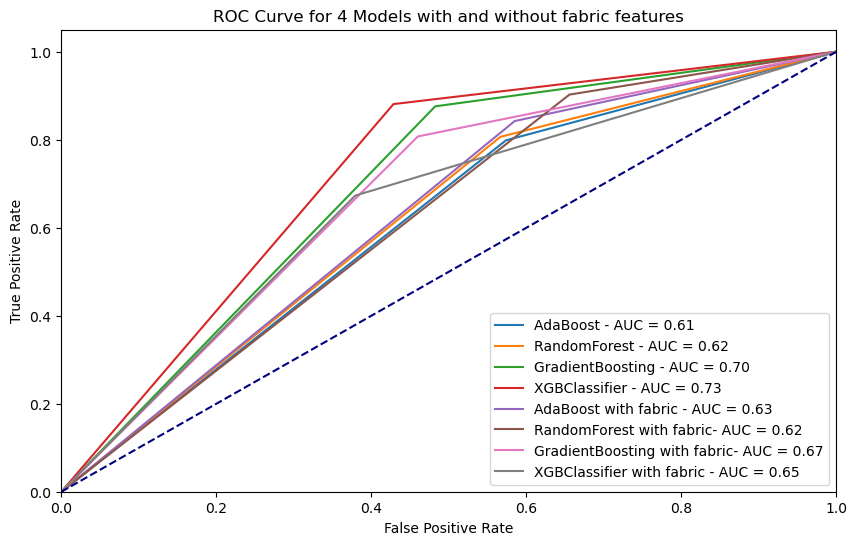

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# ROC e le AUC for each model without fabric
fpr_model1, tpr_model1, _ = roc_curve(y_test, y_test_pred_ada)
roc_auc_model1 = auc(fpr_model1, tpr_model1)

fpr_model2, tpr_model2, _ = roc_curve(y_test, y_test_pred_rf)
roc_auc_model2 = auc(fpr_model2, tpr_model2)

fpr_model3, tpr_model3, _ = roc_curve(y_test, clf_predictions)
roc_auc_model3 = auc(fpr_model3, tpr_model3)

fpr_model4, tpr_model4, _ = roc_curve(y_test, preds)
roc_auc_model4 = auc(fpr_model4, tpr_model4)

# ROC e le AUC for each model with fabric
fpr_model5, tpr_model5, _ = roc_curve(y_test, pred_ada)
roc_auc_model5 = auc(fpr_model5, tpr_model5)

fpr_model6, tpr_model6, _ = roc_curve(y_test, pred_rf)
roc_auc_model6 = auc(fpr_model6, tpr_model6)

fpr_model7, tpr_model7, _ = roc_curve(y_test, pred_gb)
roc_auc_model7 = auc(fpr_model7, tpr_model7)

fpr_model8, tpr_model8, _ = roc_curve(y_test, pred_xgb)
roc_auc_model8 = auc(fpr_model8, tpr_model8)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(fpr_model1, tpr_model1, label=f'AdaBoost - AUC = {roc_auc_model1:.2f}')
plt.plot(fpr_model2, tpr_model2, label=f'RandomForest - AUC = {roc_auc_model2:.2f}')
plt.plot(fpr_model3, tpr_model3, label=f'GradientBoosting - AUC = {roc_auc_model3:.2f}')
plt.plot(fpr_model4, tpr_model4, label=f'XGBClassifier - AUC = {roc_auc_model4:.2f}')

plt.plot(fpr_model5, tpr_model5, label=f'AdaBoost with fabric - AUC = {roc_auc_model5:.2f}')
plt.plot(fpr_model6, tpr_model6, label=f'RandomForest with fabric- AUC = {roc_auc_model6:.2f}')
plt.plot(fpr_model7, tpr_model7, label=f'GradientBoosting with fabric- AUC = {roc_auc_model7:.2f}')
plt.plot(fpr_model8, tpr_model8, label=f'XGBClassifier with fabric - AUC = {roc_auc_model8:.2f}')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for 4 Models with and without fabric features')
plt.legend(loc="lower right")
plt.savefig('roc_curve_plot_train101103.pdf')
plt.show()